# The 0-1 Knapsack Problem

The following is the implementation of this problem in the Pymoo framework,

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# First we need to install pymoo, in this case we use the  version 0.5.0

In [2]:
pip install pymoo==0.5.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 13.3 MB/s 
     |████████████████████████████████| 239 kB 84.5 MB/s 


First, we must to create a class whit the all information about the problem

In [3]:
#%%
import numpy as np

from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.core.problem import Problem
from pymoo.factory import get_crossover, get_mutation, get_sampling
from pymoo.operators.selection.tournament import TournamentSelection
from pymoo.optimize import minimize
from pymoo.problems.single.knapsack import create_random_knapsack_problem
import numpy as np
import autograd.numpy as anp
from pymoo.operators.selection.tournament import compare, TournamentSelection
from pymoo.core.problem import Problem



#in this class we implements how the individual will be measuere, we need some information about the problem, items, weights, values and maximum capacity}
#also here we need to implements the contraints too.

class Knapsack(Problem):
    def __init__(self,
                 n_items,  # number of items that can be picked up
                 W,  # weights for each item
                 V,  # profit of each item
                 C,  # maximum capacity
                 ):
        super().__init__(n_var=n_items, n_obj=1, n_constr=1, xl=0, xu=1, type_var=bool)

        self.W = W
        self.V= V
        self.C = C

    def _evaluate(self, x, out, *args, **kwargs):
        out["F"] = -anp.sum(self.V * x, axis=1)
        out["G"] = (anp.sum(self.W * x, axis=1) - self.C)




In [ ]:
This problem has constraints we need to implements a constraint handler tecnique, here the most basic called CDP (constraint dominance principle)

In [4]:



#CDP deb rule's

def comp_by_cv_and_fitness(pop, P, **kwargs):
    S = np.full(P.shape[0], np.nan)

    for i in range(P.shape[0]):
        a, b = P[i, 0], P[i, 1]

        # if at least one solution is infeasible
        if pop[a].CV > 0.0 or pop[b].CV > 0.0:
            S[i] = compare(a, pop[a].CV, b, pop[b].CV, method='smaller_is_better', return_random_if_equal=True)

        # both solutions are feasible just set random if are equal
        else:
            S[i] = compare(a, pop[a].F, b, pop[b].F, method='smaller_is_better', return_random_if_equal=True)

    return S[:, None].astype(int)


In [ ]:


# here we generates de information, 
anp.random.seed(0)
n_items=100
V = anp.random.randint(1, 100, size=n_items)
W = anp.random.randint(1, 100, size=n_items)
C = int(anp.sum(W) / 10)



#We define the technique In this case, the genetic algorithm

pop_size=100

algorithm = GA(
    pop_size=pop_size,  
    selection=TournamentSelection(func_comp=comp_by_cv_and_fitness), # the selection method is Tournament but with the opcion func_comp we define the comparation method, CDP in this problem
    sampling=get_sampling("bin_random"),
    crossover=get_crossover("bin_one_point"),
    mutation=get_mutation("bin_bitflip"),
    eliminate_duplicates=True)
n_gen=1000
res = minimize(Knapsack(n_items,W,V,C), # whit this opcion we star the algorithm 
               algorithm,
               ('n_gen', n_gen),
               verbose=False,  
               save_history=True)

print("Best solution found: %s" % res.X.astype(int))
print("Function value: %s" % (res.F*-1))
print("Constraint violation: %s" % res.CV)





We can plot the best fitness in each generation

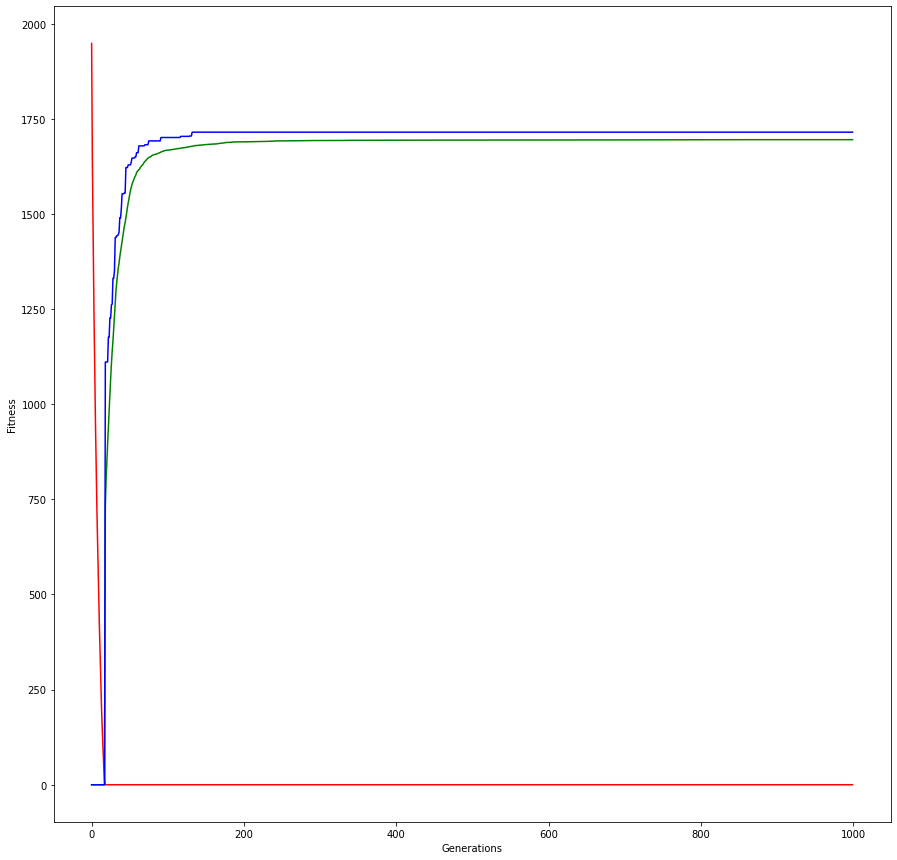

In [21]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15,15]

fitness=[]
cvs=[]
best_fit=[]
for i in range(n_gen):
    F=res.history[i].pop.get("F").sum()/pop_size
    cv = res.history[i].pop.get("CV").sum() / pop_size
    Fb=res.history[i].pop.get("F").min()

    cvs.append(cv)
    if res.history[i].pop.get("CV").sum()==0:
        fitness.append(F*-1)
        best_fit.append(Fb*-1)
    else:
        fitness.append(0)
        best_fit.append(0)


p = plt.plot(range(n_gen),cvs, color='red')  #Constraint violation
p = plt.plot(range(n_gen),fitness,color='green') #Mean Fitness
p = plt.plot(range(n_gen),best_fit, color='blue') # best Fitness

plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.show()
